# 从kaggle下载数据集

In [1]:
!cp /content/drive/MyDrive/kaggle.json /content/

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [2]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 98% 118M/121M [00:04<00:00, 30.9MB/s]
100% 121M/121M [00:04<00:00, 26.4MB/s]


In [4]:
!unzip /content/face-expression-recognition-dataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating: images/validation/fear/

# 导入python包

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
import copy

# 超参数设置

In [6]:
batch_size = 16
epochs = 10
learning_rate = 0.01
img_width= 224
img_height= 224

# 数据预处理pipline

## 准备dataset

In [7]:
train_dir = '/content/images/train'
test_dir = '/content/images/validation'

In [8]:
train_transform = transforms.Compose([
                    transforms.RandomRotation(5),
                    transforms.RandomHorizontalFlip(),
                    transforms.Resize((img_width,img_width)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

In [9]:
train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
test_ds = datasets.ImageFolder(test_dir, transform=train_transform)

# train_ds_mini = torch.utils.data.Subset(train_ds,range(1000))
# test_ds_mini = torch.utils.data.Subset(test_ds,range(500))
train_ds_mini,test_ds_mini = torch.utils.data.random_split(test_ds,[6066,1000])
# train_ds_mini,test_ds_mini = torch.utils.data.random_split(test_ds_mini,[800,200])

print(len(train_ds),len(test_ds))
len(train_ds_mini),len(test_ds_mini)

28821 7066


(6066, 1000)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
train_ds.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
num_classes = len(train_ds.classes)
num_classes

7

In [13]:
train_ds[0][0].shape,train_ds[0][1]

(torch.Size([3, 224, 224]), 0)

## 准备dataloader

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# train_dl = torch.utils.data.DataLoader(train_ds_mini, batch_size=batch_size, shuffle=True)
# test_dl = torch.utils.data.DataLoader(test_ds_mini, batch_size=batch_size, shuffle=True)

## 确定数据输入shape

In [15]:
b_img,b_label = next(iter(train_dl))
b_img.shape,b_label.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [16]:
b_label

tensor([5, 5, 6, 4, 5, 4, 3, 6, 4, 2, 2, 2, 4, 2, 0, 3])

# 确认GPU CPU使用情况

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 训练和评估循环

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (img_rgb, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)
        img_rgb = img_rgb.to(device)

        y = y.to(device)

        # Compute prediction error
        pred = model(img_rgb)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(img_rgb)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (img_rgb, y) in dataloader:
            img_rgb = img_rgb.to(device)

            y = y.to(device)

            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

# 模型 resnet18

## 构建基础模型

In [19]:

base_model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = base_model_resnet18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
base_model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

base_model_resnet18 = base_model_resnet18.to(device)

base_model_resnet18(b_img.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.7MB/s]


torch.Size([16, 7])

In [20]:
base_model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 分配损失函数和优化器

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_resnet18.parameters(), lr=1e-3)

## 训练和评估

In [22]:
%%time
epochs = 60
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, base_model_resnet18, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, base_model_resnet18, loss_fn)
    test_loss, test_correct = test(test_dl, base_model_resnet18, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 1.998490  [    0/28821]
loss: 1.766545  [  800/28821]
loss: 1.805769  [ 1600/28821]
loss: 1.799652  [ 2400/28821]
loss: 1.782786  [ 3200/28821]
loss: 2.075965  [ 4000/28821]
loss: 1.760292  [ 4800/28821]
loss: 1.804137  [ 5600/28821]
loss: 1.506667  [ 6400/28821]
loss: 1.597832  [ 7200/28821]
loss: 1.551606  [ 8000/28821]
loss: 1.560494  [ 8800/28821]
loss: 1.859120  [ 9600/28821]
loss: 1.495449  [10400/28821]
loss: 1.869239  [11200/28821]
loss: 1.898965  [12000/28821]
loss: 1.728460  [12800/28821]
loss: 1.584316  [13600/28821]
loss: 1.805674  [14400/28821]
loss: 1.458148  [15200/28821]
loss: 1.430799  [16000/28821]
loss: 1.524960  [16800/28821]
loss: 1.620975  [17600/28821]
loss: 1.254193  [18400/28821]
loss: 1.454575  [19200/28821]
loss: 1.365857  [20000/28821]
loss: 2.089342  [20800/28821]
loss: 1.307052  [21600/28821]
loss: 1.960051  [22400/28821]
loss: 1.246946  [23200/28821]
loss: 1.196866  [24000/28821]
loss: 1.491096  [24800/28821]


## 可视化训练过程

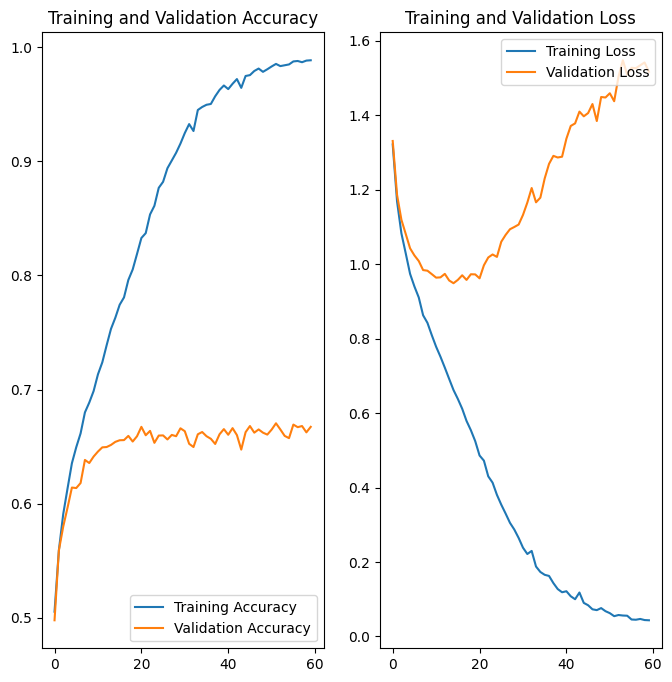

In [23]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 模型验证集预测

In [24]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dl:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_resnet18(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([1.1997402e-04, 9.2224794e-04, 5.3320105e-06, 5.3214229e-05,
        4.8274120e-05], dtype=float32),
 array([0, 2, 2, 6, 0]),
 array([2, 0, 2, 5, 4]))

### 分类报告

In [25]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.552     0.598     0.574       960
           1      0.638     0.730     0.681       111
           2      0.545     0.511     0.527      1018
           3      0.866     0.854     0.860      1825
           4      0.635     0.574     0.603      1216
           5      0.501     0.572     0.534      1139
           6      0.819     0.765     0.791       797

    accuracy                          0.664      7066
   macro avg      0.651     0.658     0.653      7066
weighted avg      0.670     0.664     0.666      7066



### 混淆矩阵

In [26]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 574,   16,  106,   34,   69,  147,   14],
       [  14,   81,    7,    2,    2,    4,    1],
       [ 134,   12,  520,   30,   74,  191,   57],
       [  48,    1,   40, 1559,   79,   69,   29],
       [ 107,    6,   74,  100,  698,  214,   17],
       [ 133,   10,  132,   41,  154,  652,   17],
       [  29,    1,   75,   34,   24,   24,  610]])

<Axes: >

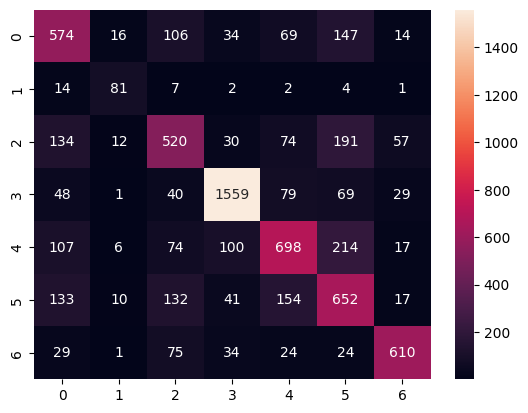

In [27]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

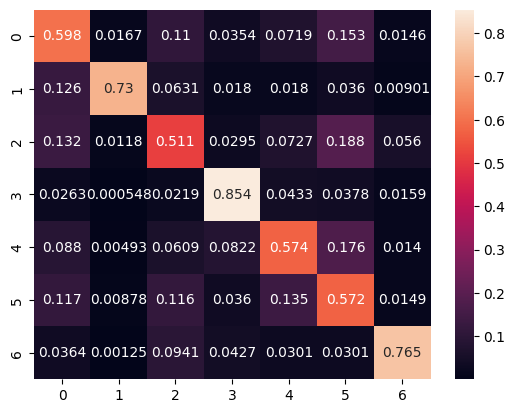

In [28]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3g')